In [7]:
from cities.deployment.tracts_minneapolis.predict import TractsModelPredictor
from cities.utils.data_loader import db_connection
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import xetcache


        Usage:

           %%xetmemo input=v1,v2 output=v3,v4

        Caches the specified output variables each time it is called.
        If called later with the same inputs , the cached value is returned
        and not reevaluated. This is persistent across Python runs.

        Any content changes to the input input variables, or cell code will
        force reevaluation of the cell. Otherwise the outputs will simply be
        retrieved from the memo.

        This memo is persistent across Python processes and if XetHub is used
        see `xetcache.set_xet_project`, can be shared with others.

        For performance reasons, only functions which take more than 3
        seconds (configurable from config.set_runtime_threshold) will be 
        cached. "always=True" can be added to the xetmemo arguments to
        ignore the runime and to always cache

           %%xetmemo input=v1,v2 output=v3,v4 always=True

        Note that inputs can be anything picklable including funct

In [8]:
%%xetmemo output=result,result_extreme

start = time.time()
with db_connection() as conn:
    predictor = TractsModelPredictor(conn)
    

    result = predictor.predict_cumulative(
        conn,
        intervention={
            "radius_blue": 350,
            "limit_blue": 0,
            "radius_yellow_line": 1320,
            "radius_yellow_stop": 2640,
            "limit_yellow": 0.5,
            "reform_year": 2015,
        },
    )

with db_connection() as conn:
    predictor = TractsModelPredictor(conn)
    result_extreme = predictor.predict_cumulative(
        conn,
        intervention={
            "radius_blue": 1450,
            "limit_blue": 0,
            "radius_yellow_line": 2640,
            "radius_yellow_stop": 2640,
            "limit_yellow": 0.3,
            "reform_year": 2012,
        },
    )
end = time.time()
print("Time elapsed:", end - start)


Time elapsed: 12.475860118865967
Writing to 41d1f4cf3258dbff3579ec934ea576b21e31c157ed077d959d4d50b3ac47c018.pickle


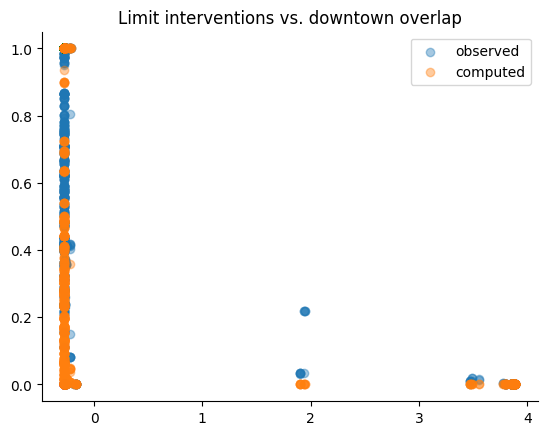

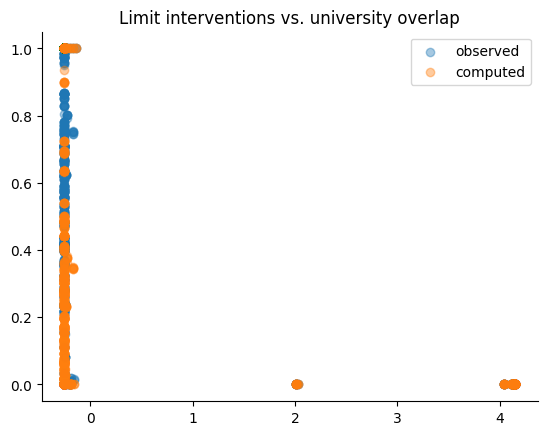

In [9]:
plt.scatter(predictor.data['continuous']['downtown_overlap'], predictor.data['continuous']['mean_limit_original'], 
            label='observed', alpha = .4)
plt.scatter(predictor.data['continuous']['downtown_overlap'], result['limit_intervention'], label='computed', alpha = .4)
plt.legend()
sns.despine()
plt.title('Limit interventions vs. downtown overlap')
plt.show()

plt.scatter(predictor.data['continuous']['university_overlap'], predictor.data['continuous']['mean_limit_original'], label='observed', alpha = .4)
plt.scatter(predictor.data['continuous']['university_overlap'], result['limit_intervention'], label='computed', alpha = .4)
plt.legend()
sns.despine()
plt.title('Limit interventions vs. university overlap')
plt.show()



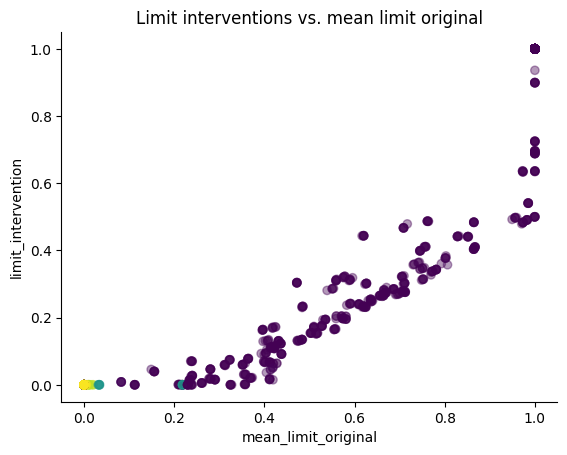

tensor(38)

In [10]:
# scatter limit_intervention vs. mean_limit_original
plt.scatter(predictor.data['continuous']['mean_limit_original'],
             result['limit_intervention'], alpha = .4,
            c = predictor.data['continuous']['downtown_overlap'])
plt.xlabel('mean_limit_original')
plt.ylabel('limit_intervention')
sns.despine()
plt.title('Limit interventions vs. mean limit original')
plt.show()
()
((predictor.data['continuous']['mean_limit_original'] >.99).int() * (result['limit_intervention'] < .99).int()).sum()

# this still doesn't seem like the factual setting


In [11]:
def plot_pred_timelines(unique_string, result, suptitle):

    key = [key for key in result['obs_cumsums'].keys() if unique_string in str(key)][0]

    downtown_overlap = predictor.data['continuous']['downtown_overlap'][predictor.tracts == key][0]
    university_overlap = predictor.data['continuous']['university_overlap'][predictor.tracts == key][0]

    obs = result['obs_cumsums'][key]
    quantiles = torch.tensor([0.005, 0.5, 0.995])

    f_variances = result['f_cumsums'][key].var(dim=1)
    cf_variances = result['cf_cumsums'][key].var(dim=1)


    f_summaries = result['f_cumsums'][key].quantile(quantiles, dim=1).clamp(min=0)
    cf_summaries = result['cf_cumsums'][key].quantile(quantiles, dim=1).clamp(min=0)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(predictor.years.unique(), obs, label='observed')
    ax1.plot(predictor.years.unique(), f_summaries[1,], label='predicted')
    ax1.fill_between(predictor.years.unique(), f_summaries[0,], f_summaries[2,], 
                    alpha=0.4)
    ax1.legend()
    ax1.set_title(f'Predicted, 99% CI (downtown: {downtown_overlap:.2f}, '
              f'university: {university_overlap:.2f})')
    sns.despine(ax=ax1)


    ax2.plot(predictor.years.unique(), obs, label='observed')
    ax2.plot(predictor.years.unique(), cf_summaries[1,], label='counterfactual')
    ax2.fill_between(predictor.years.unique(), cf_summaries[0,], cf_summaries[2,], 
                    alpha=0.4)
    ax2.legend()
    ax2.set_title('Counterfactual, 99% CI')
    sns.despine(ax=ax2)

    fig.suptitle(suptitle)
    plt.show()



def plot_counterfactual_vs_predicted(unique_string, result, suptitle):
        
        key = [key for key in result['obs_cumsums'].keys() if unique_string in str(key)][0]

        downtown_overlap = predictor.data['continuous']['downtown_overlap'][predictor.tracts == key][0]
        university_overlap = predictor.data['continuous']['university_overlap'][predictor.tracts == key][0]

        quantiles = torch.tensor([0.005, 0.5, 0.995])
    
        f_variances = result['f_cumsums'][key].var(dim=1)
        cf_variances = result['cf_cumsums'][key].var(dim=1)
    
        f_summaries = result['f_cumsums'][key].quantile(quantiles, dim=1).clamp(min=0)
        cf_summaries = result['cf_cumsums'][key].quantile(quantiles, dim=1).clamp(min=0)
    
        fig, axes = plt.subplots(2, 2, figsize=(12, 6))
        ax1, ax2, ax3, ax4 = axes.flat 
    
        ax1.plot(predictor.years.unique(), result['obs_limits'][key], 
                   label='observed')
        ax1.plot(predictor.years.unique(),
                  result['cf_limits'][key], label='counterfactual')
        ax1.legend()
        ax1.set_title(f'Mean limits (downtown: {downtown_overlap:.2f}, '
                  f'university: {university_overlap:.2f})')


        ax2.plot(predictor.years.unique(), f_summaries[1,], label='predicted')
        ax2.plot(predictor.years.unique(), cf_summaries[1,], label='counterfactual')
        ax2.fill_between(predictor.years.unique(), cf_summaries[0,], cf_summaries[2,], 
                        alpha=0.4)
        ax2.legend()
        ax2.set_title('Predicted vs counterfactual, 99% CI') 
        
        last_year_idx = -1  
        #last_predicted = result['f_cumsums'][key][last_year_idx,:].detach().cpu().numpy()
        last_counterfactual = result['cf_cumsums'][key][last_year_idx,:].detach().cpu().numpy()
        last_factual_mean = result['f_cumsums'][key][last_year_idx,:].mean().detach().cpu().numpy()
        intervened_diff = np.abs(last_factual_mean - last_counterfactual.mean())


        ax3.hist(last_counterfactual, bins=30, alpha=0.7, label='counterfactual', color='skyblue')
        ax3.axvline(f_summaries[1, last_year_idx], color='blue', linestyle='--', label='median predicted')
        ax3.axvline(cf_summaries[1, last_year_idx], color='red', linestyle='--', label='median counterfactual')
        ax3.set_title('Histogram of counterfactual (Last Year)')
        ax3.legend()


        ax4.hist(last_counterfactual, bins=30, alpha=0.7, label='counterfactual', color='skyblue')
        ax4.axvline(f_summaries[1, last_year_idx], color='blue', linestyle='--', label='median predicted')
        ax4.axvline(cf_summaries[1, last_year_idx], color='red', linestyle='--', label='median counterfactual')
        ax4.set_title('Histogram of counterfactual (Last Year)')
        ax4.set_xlim(cf_summaries[1, last_year_idx]-2 * intervened_diff, cf_summaries[1, last_year_idx]+ 2 * intervened_diff)
        ax4.legend()

        fig.suptitle(suptitle)
        sns.despine()
        plt.tight_layout()
        plt.show()

        

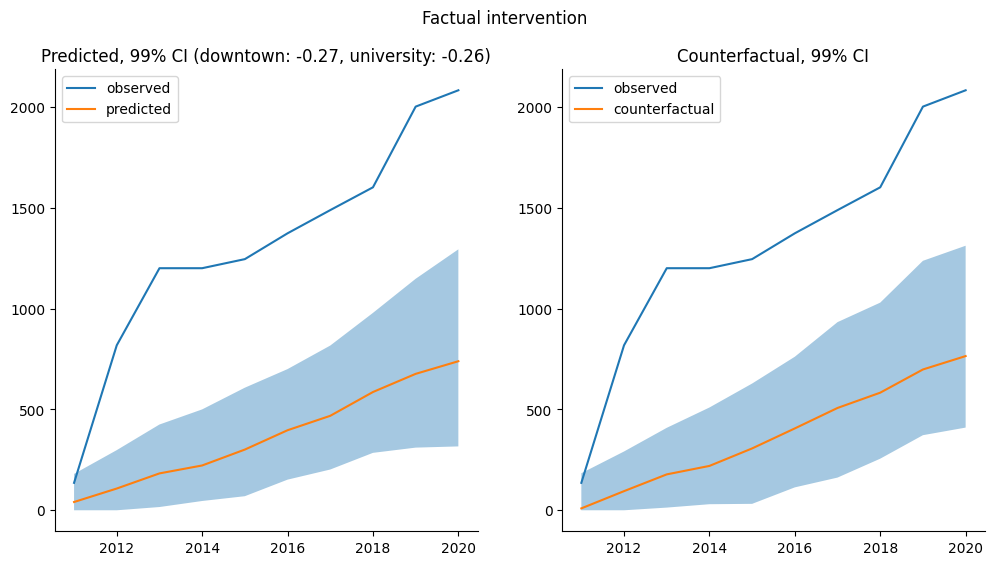

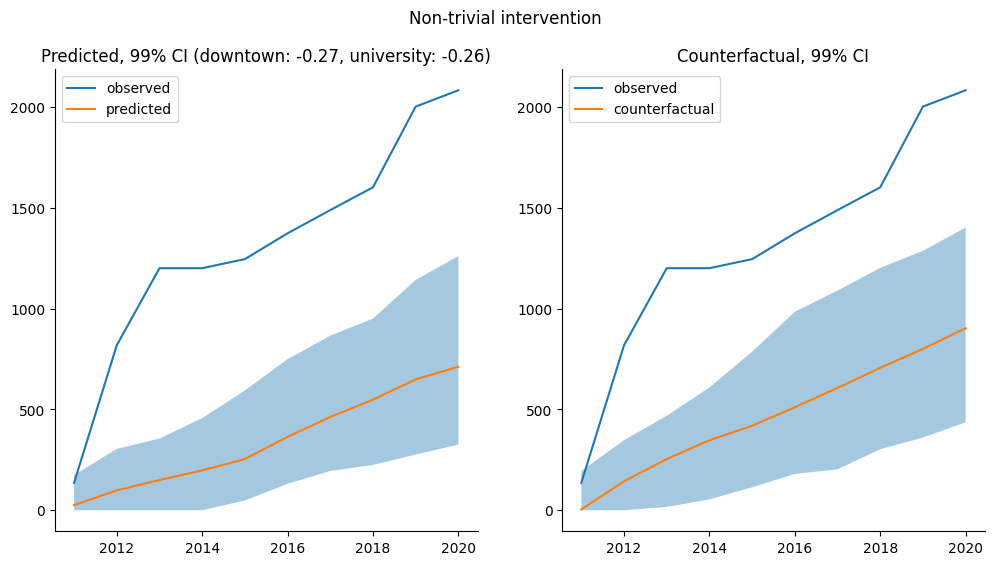

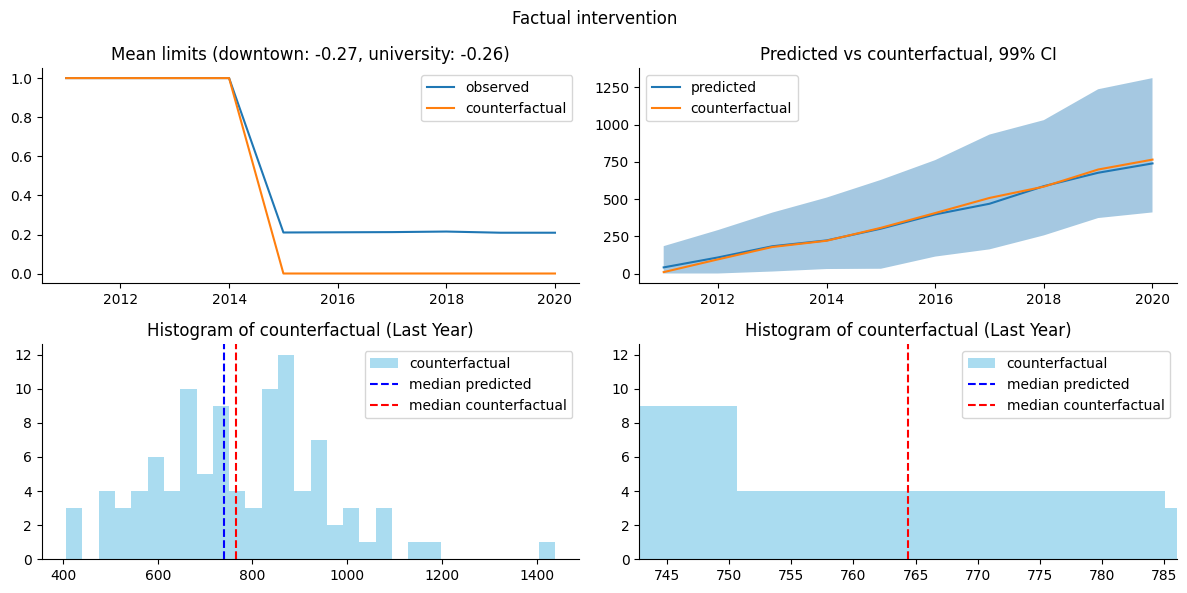

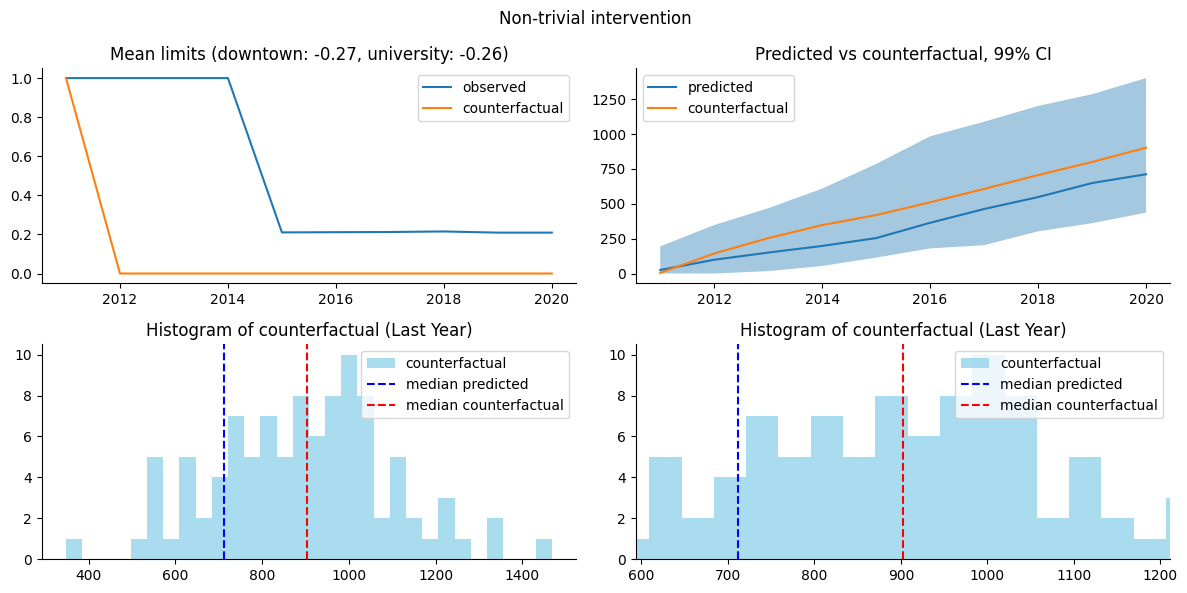

In [12]:
plot_pred_timelines("77", result, "Factual intervention")
plot_pred_timelines("77", result_extreme, "Non-trivial intervention")

plot_counterfactual_vs_predicted("77", result, "Factual intervention")
plot_counterfactual_vs_predicted("77", result_extreme, "Non-trivial intervention")

#TODO check if not a data problem

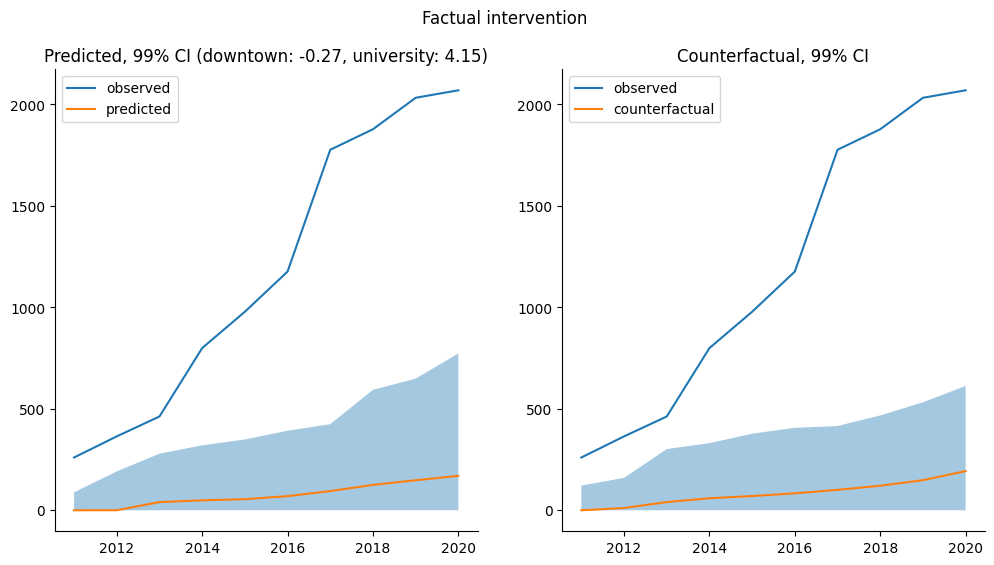

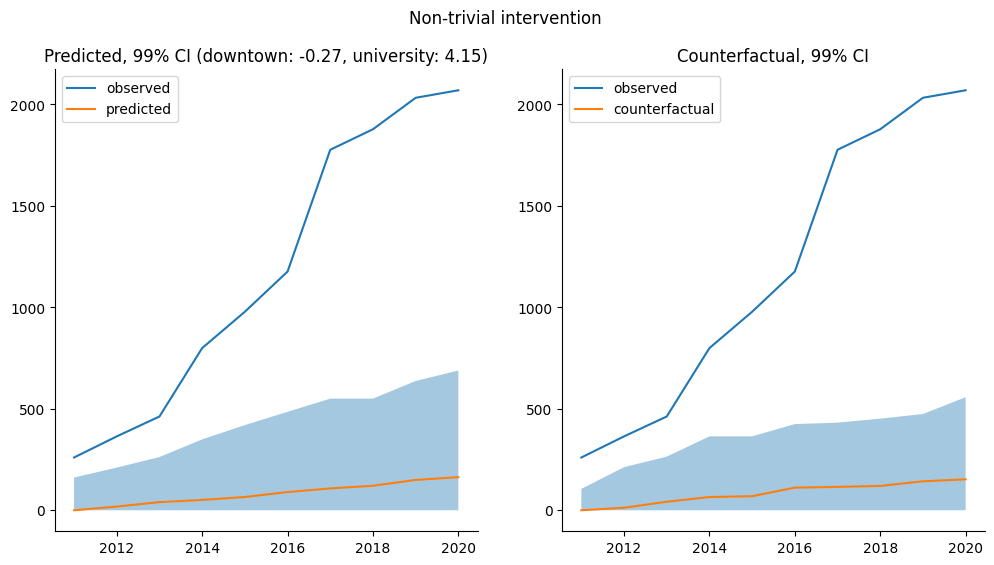

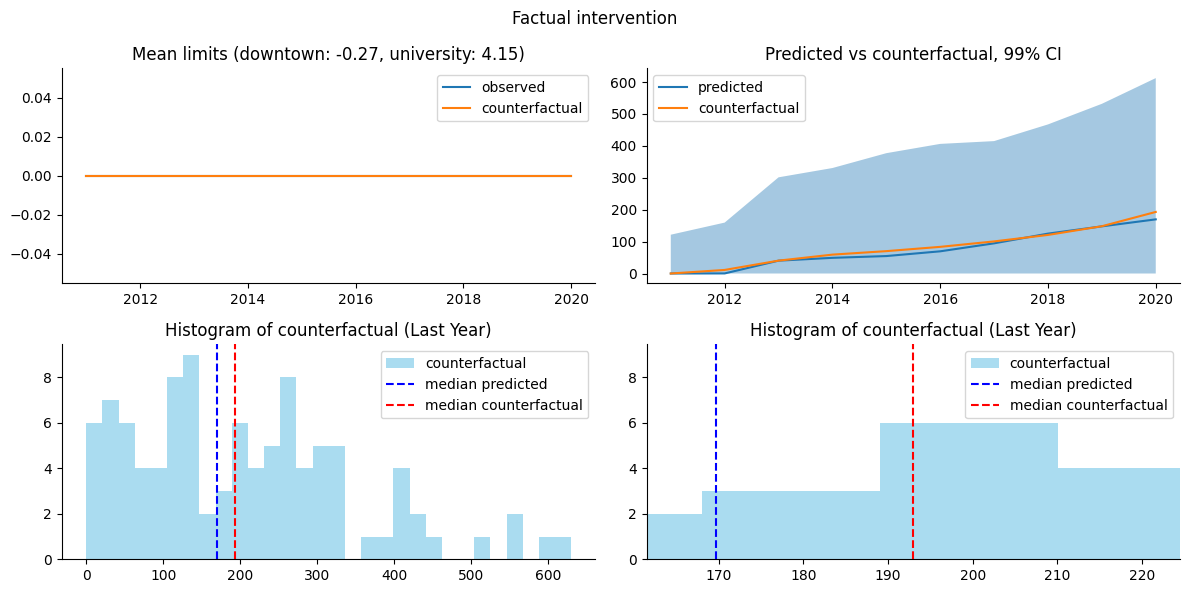

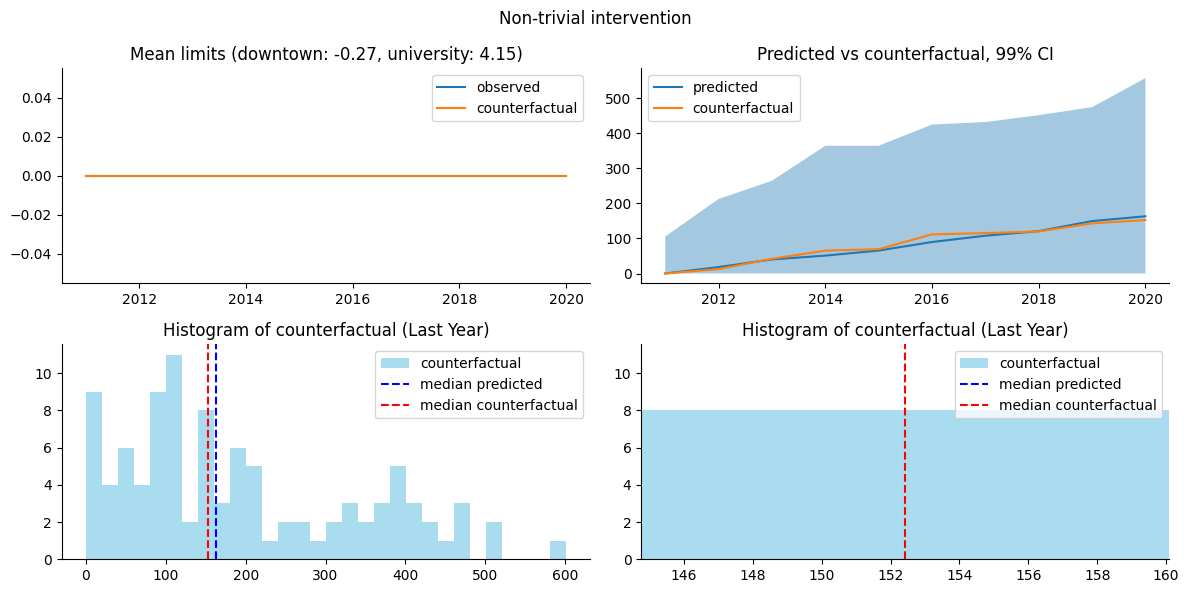

In [13]:
plot_pred_timelines('1049', result, "Factual intervention")
plot_pred_timelines('1049', result_extreme, "Non-trivial intervention")
plot_counterfactual_vs_predicted('1049', result, "Factual intervention")
plot_counterfactual_vs_predicted('1049', result_extreme, "Non-trivial intervention")

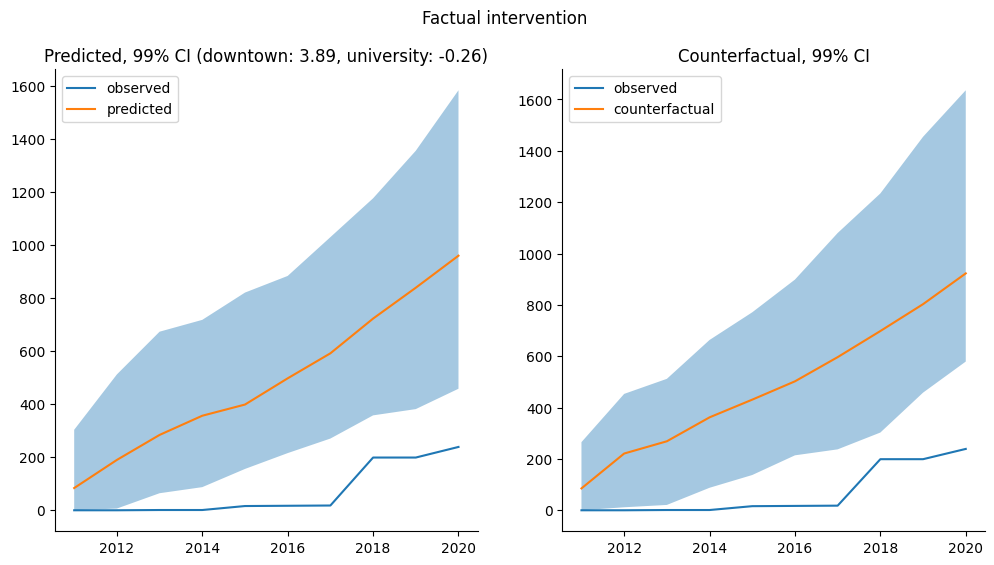

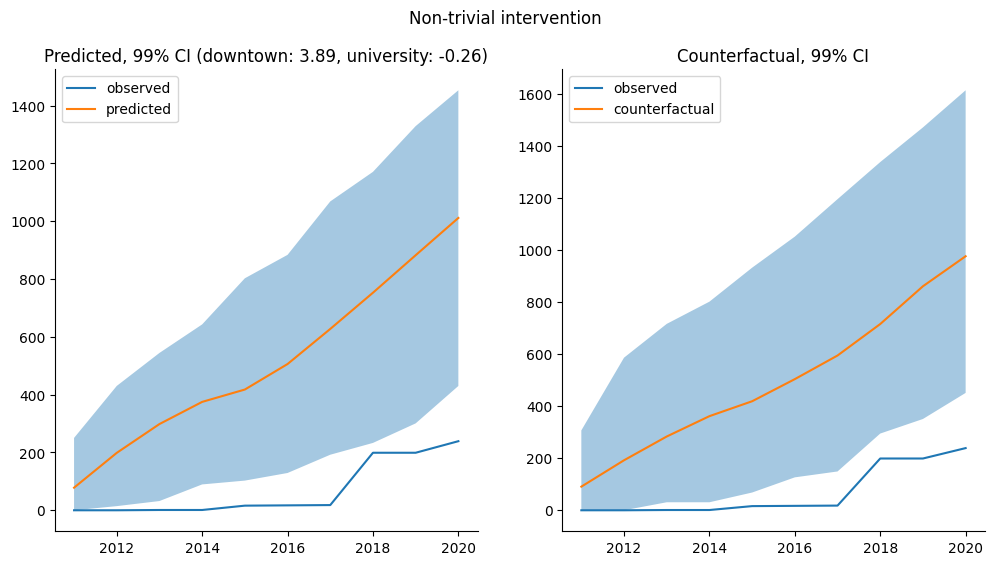

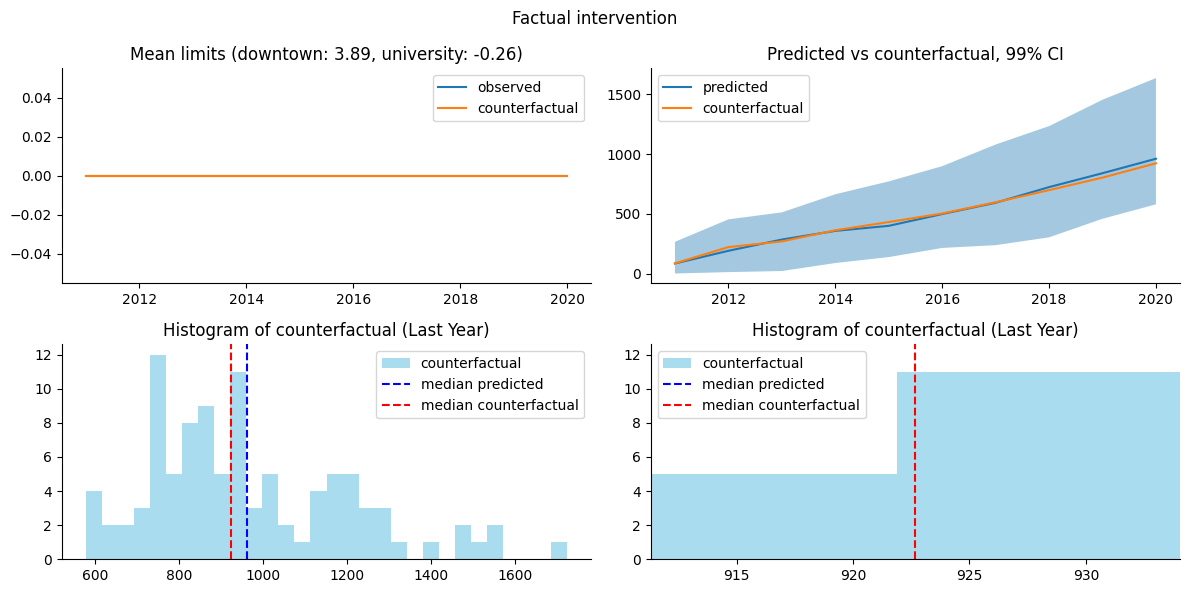

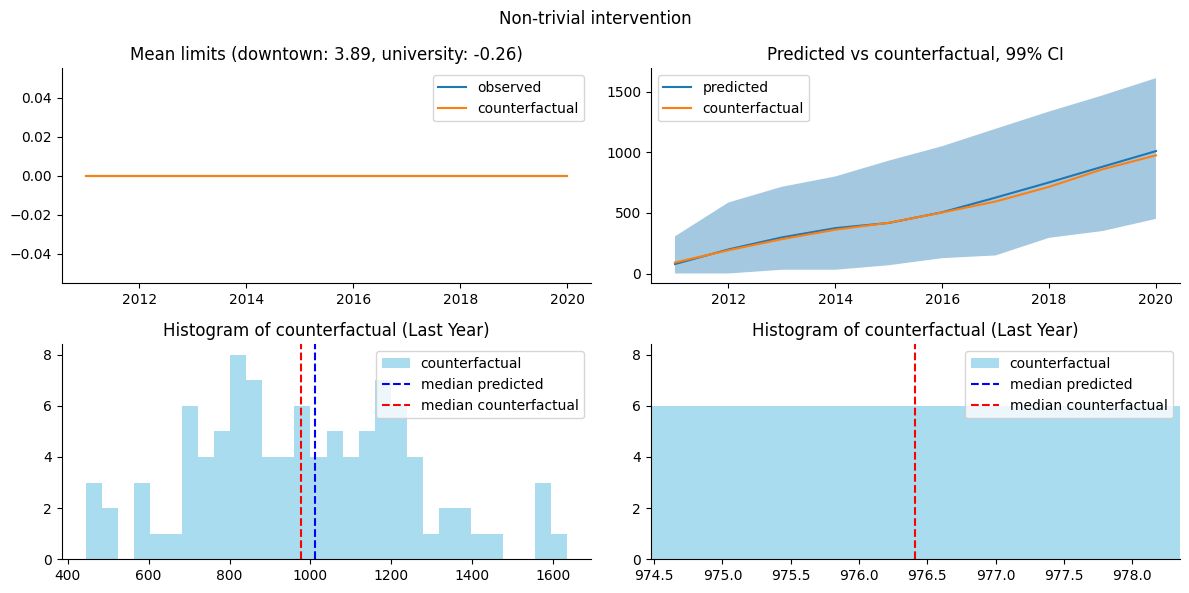

In [14]:
plot_pred_timelines('105201', result, "Factual intervention")
plot_pred_timelines('105201', result_extreme, "Non-trivial intervention")
plot_counterfactual_vs_predicted('105201', result, "Factual intervention")
plot_counterfactual_vs_predicted('105201', result_extreme, "Non-trivial intervention")

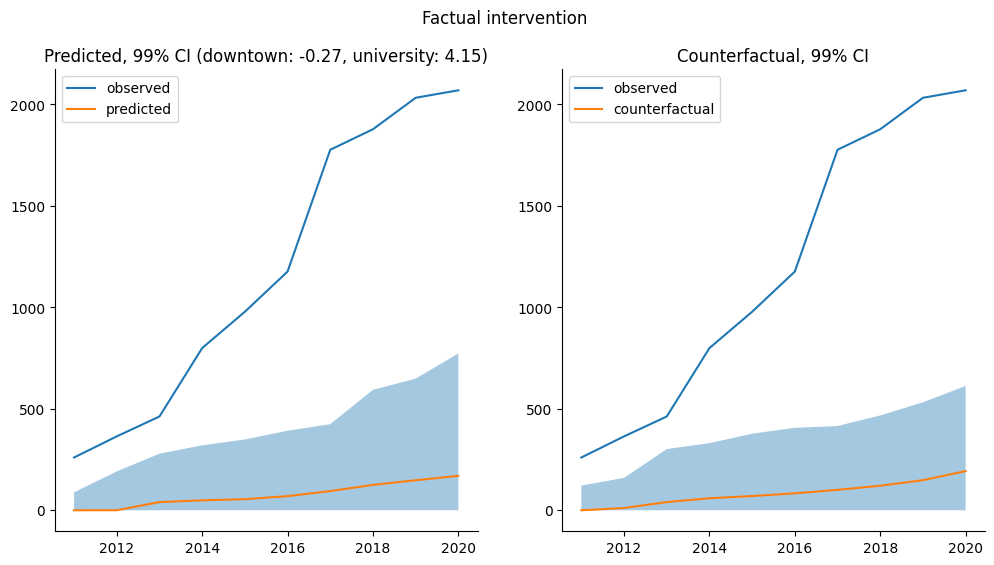

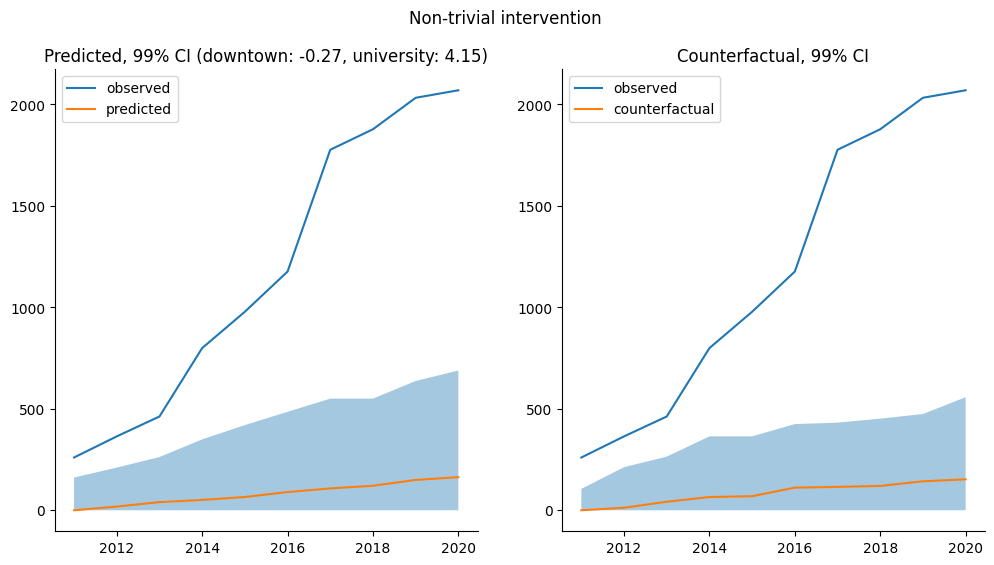

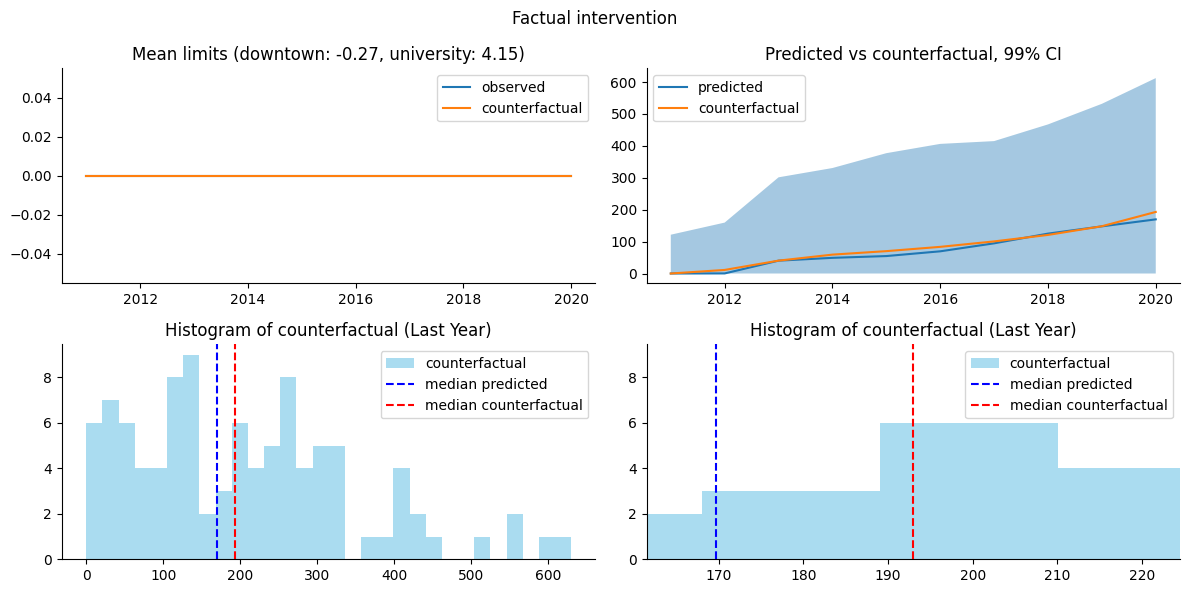

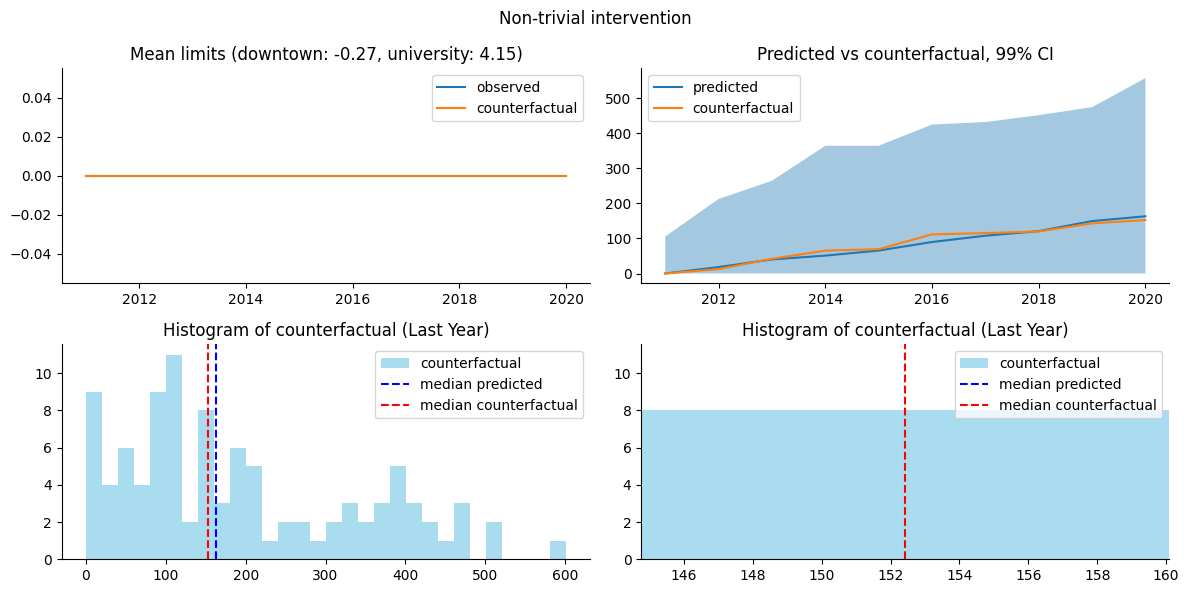

In [15]:
plot_pred_timelines('104900', result, "Factual intervention")
plot_pred_timelines('104900', result_extreme, "Non-trivial intervention")
plot_counterfactual_vs_predicted('104900', result, "Factual intervention")
plot_counterfactual_vs_predicted('104900', result_extreme, "Non-trivial intervention")

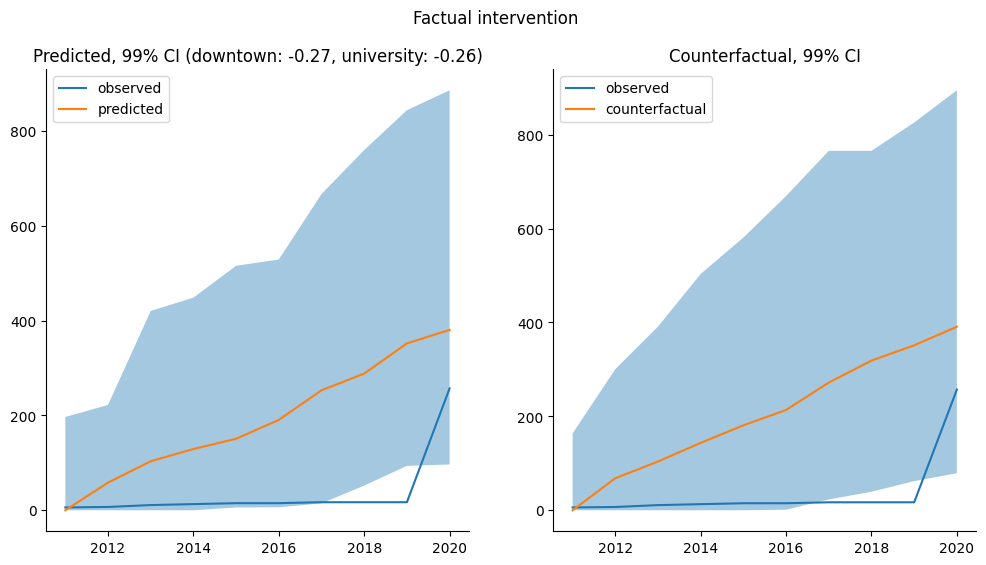

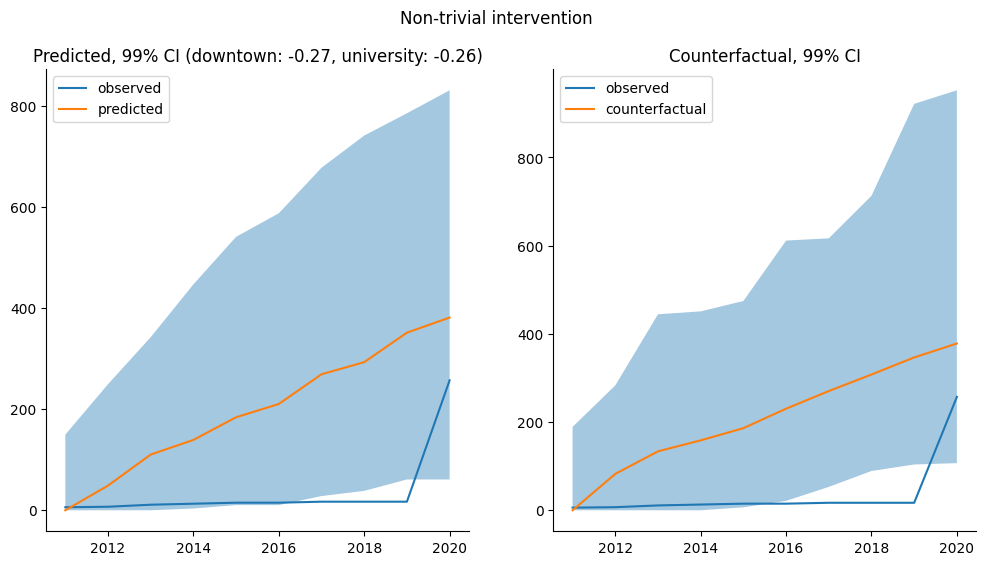

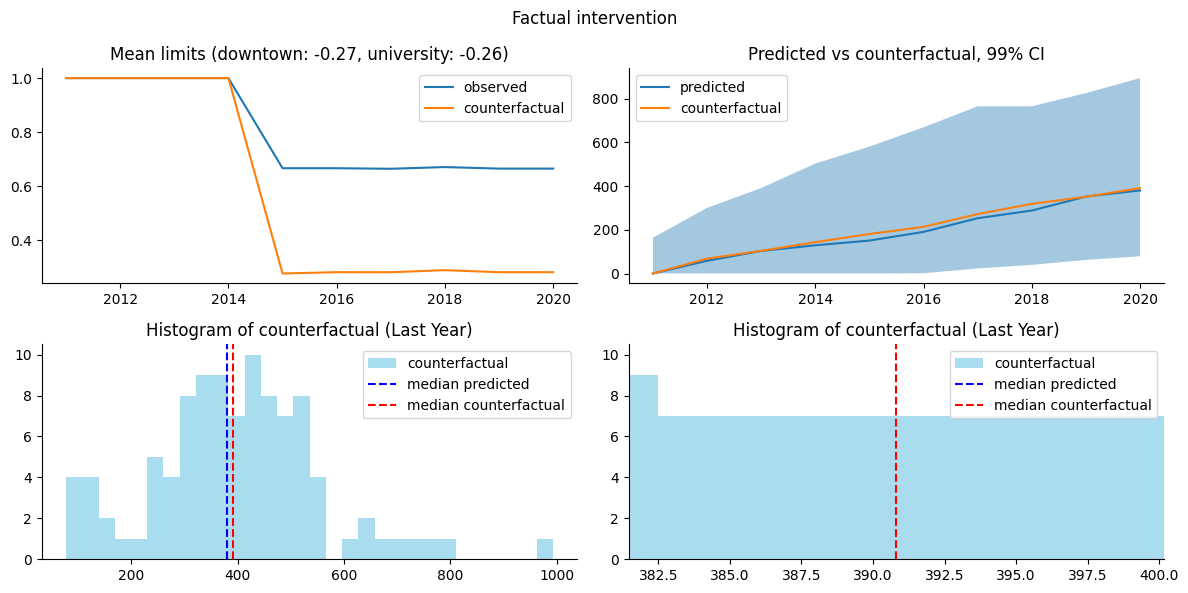

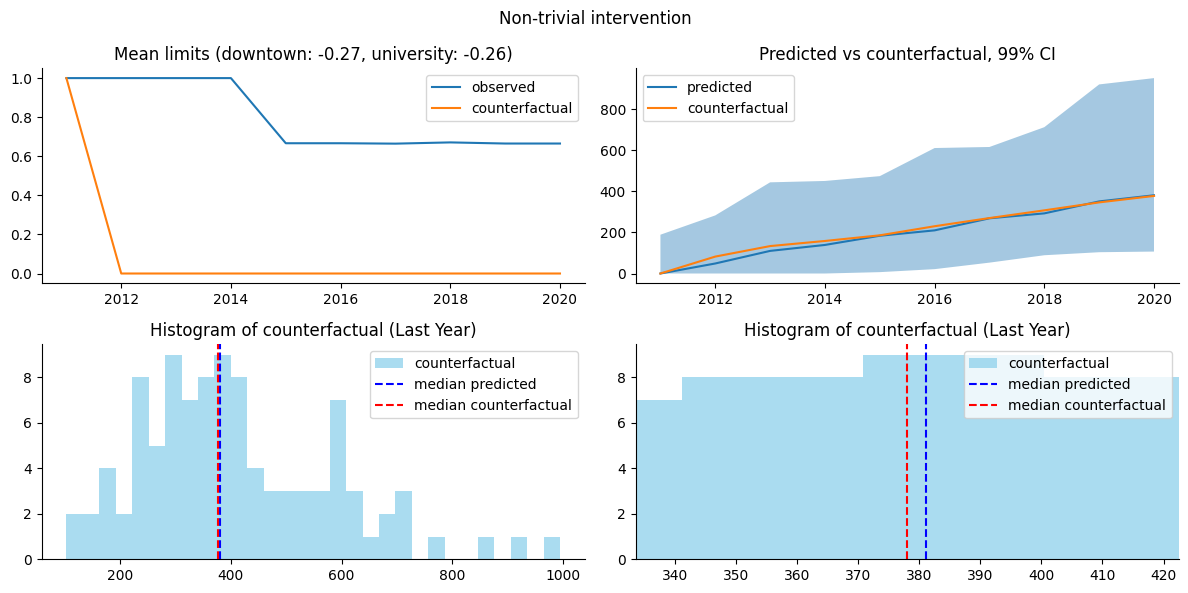

In [16]:
key = "23"
plot_pred_timelines(key, result, "Factual intervention")
plot_pred_timelines(key, result_extreme, "Non-trivial intervention")
plot_counterfactual_vs_predicted(key, result, "Factual intervention")
plot_counterfactual_vs_predicted(key, result_extreme, "Non-trivial intervention")